In [2]:
# Real life data

%load_ext autoreload
import logging
import threading
import itertools
import warnings
import pandas as pd  
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
from mmfunctions.telemanom import (TelemanomConfig, TelemanomModel, TelemanomEstimator, LSTMRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
from scipy.stats import wasserstein_distance, energy_distance, gaussian_kde
import skimage as ski

from skimage import util as skiutil # for nifty windowing
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import tspy

EngineLogging.configure_console_logging(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# from https://stackoverflow.com/questions/43297853/modifying-timestamps-in-pandas-to-make-index-unique/43298598
def deal_with_duplicate_ts(df):
    # get duplicated values as float and replace 0 with NaN
    values = df.index.duplicated(keep=False).astype(float)
    values[values==0] = np.NaN

    missings = np.isnan(values)
    cumsum = np.cumsum(~missings)
    diff = np.diff(np.concatenate(([0.], cumsum[missings])))
    values[missings] = -diff

    # print result
    df.index = df.index + np.cumsum(values).astype(np.timedelta64)
    return df

In [4]:
df_input_raw = pd.read_csv('./FloatIOPointInformationCakebread128.csv', index_col=False, parse_dates=['timestamp'])
df_input_raw['temperature'] = df_input_raw['floatvalue']

df_input = df_input_raw[['deviceid','timestamp','temperature']]

df_input = df_input.set_index(['timestamp'])
df_input = deal_with_duplicate_ts(df_input)

df_input = df_input.reset_index().set_index(['deviceid','timestamp'])

temperature = df_input['temperature'].values.reshape(-1,1)

temperature_scale = RobustScaler().fit(temperature).transform(temperature)


df_input['temperature'] = temperature_scale
df_input.size

10540

#### Change point detection with tspy
aka timeseries-insights

Actually I never finished because it requires running a python to java bridge and I'm too lazy to start the docker container ... 
so no results here.

In [4]:
#
# tspy doesn't like pandas indices
#
ts = tspy.time_series.df(df_input.reset_index(), "timestamp", "temperature")
#print(ts)

2020-08-24T16:05:55.709 INFO py4j.java_gateway.run Callback Server Starting
2020-08-24T16:05:55.710 INFO py4j.java_gateway.run Socket listening on ('127.0.0.1', 43549)


#### Change point detection the traditional way

Using RulSIF (Relative unconstrained Least-Squares Importance Fitting).
This (original) method approximates the true density ratio with a mixed Gaussian, see https://arxiv.org/pdf/2001.06386v1.pdf
for other approaches to RulSIF.

In [28]:
from densratio import densratio

# temperature reading from 00:36:00 to 09:24:00
x = df_input['temperature'][0:999].to_numpy()

# temperature reading from 00:09:24 to 17:33:00
y = df_input['temperature'][1000:1999].to_numpy()

result = densratio(x, y, alpha=0, verbose=False)


In [29]:
print(result)

Method: RuLSIF

Alpha: 0

Kernel Information:
  Kernel type: Gaussian
  Number of kernels: 100
  Bandwidth(sigma): 0.1
  Centers: matrix([[-0.8],..

Kernel Weights (theta):
  array([0.03724229, 0.23180466, 0.04209275, 0.03724229, 0.21300849,..

Regularization Parameter (lambda): 0.1

Alpha-Relative PE-Divergence: 0.3657723020259408

Alpha-Relative KL-Divergence: -0.5989675648361564

Function to Estimate Density Ratio:
  compute_density_ratio(x)
  


Hmm, a strongly **negative** KL divergence. I don't want to hunt this bug down today
.. looking for another library.
<br>

#### Change point detection with PELT

See here for an concise intro 
https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/

(includes a reference to the original paper)



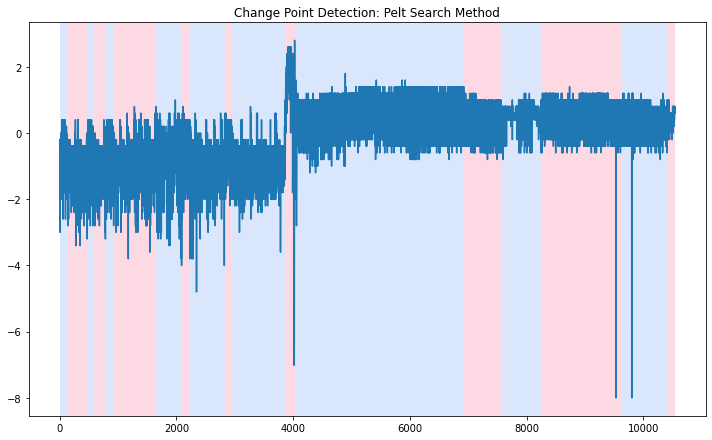

In [32]:
import ruptures as rpt

y = df_input['temperature'].to_numpy()

model = rpt.Pelt(model='rbf').fit(y)
results = model.predict(pen=10)

rpt.display(y, results, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 